# Differential Peak Shape

**Created**: 24 April 2022

## Environment

In [1]:
if (!requireNamespace("limma", quietly=TRUE)) {
    BiocManager::install("limma")
}

if (!requireNamespace("Rtsne")) {
    install.packages("Rtsne")
}

Loading required namespace: Rtsne



In [2]:
library(tidyverse)
library(data.table)
library(limma)
library(Rtsne)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Load Data

In [3]:
shape.features <- fread("/nfs/users/nfs_n/nm18/gains_team282/epigenetics/regulation/immune/shape_features/consensus_coverage_pcs.csv") %>%
    as.data.frame()

In [4]:
dim(shape.features)

[1]    178 296576

In [5]:
peak.counts <- fread("/nfs/users/nfs_n/nm18/gains_team282/epigenetics/accessibility/analysis/atac_seq/immune/peak_counts.tsv")

In [6]:
peaks.with.20 <- peak.counts$GeneID[apply(as.matrix(peak.counts[,-(1:5)]) > 20, 1, function(x) { sum(x) / length(x) }) > 0.8]

In [7]:
length(peaks.with.20)

[1] 71021

In [8]:
samples <- shape.features$Sample
shape.features <- shape.features[, colnames(shape.features) %in% peaks.with.20]
shape.features$Sample <- samples

In [9]:
head(shape.features)

,1:821473-823221,1:826611-827935,1:843926-844917,1:869497-870403,1:909961-911781,1:912246-914377,1:919563-922160,1:926948-928077,1:932167-933476,1:934987-936229,⋯,X:155094280-155094963,X:155215552-155217426,X:155262831-155264951,X:155577382-155578597,X:155611879-155613388,X:155632225-155633029,X:155767025-155768038,X:155819819-155820444,X:155880556-155882240,Sample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,-0.09315448,0.121237706,0.09536164,0.019129412,0.0484123578,0.07096066,0.03970514,-0.0129956797,0.019711299,-0.041902908,⋯,-0.028662928,-0.08639159,-0.068559316,0.019042308,-0.07678982,4.374933e-03,0.11366738,0.007816609,-0.09033178,Calderon-1001-Bulk_B-Control
2,-0.01872697,-0.001298802,-0.06382523,-0.018977779,-0.0352897751,0.06847784,0.02865571,0.0004393535,0.042316976,-0.030137592,⋯,0.007777063,-0.10513312,-0.108914694,-0.023428483,-0.09744444,9.400204e-03,-0.02641936,-0.099838135,-0.10589778,Calderon-1001-Bulk_B-Treatment_1
3,0.02158755,0.041197072,-0.05750857,0.009074324,0.0240896927,0.01659894,-0.01714727,-0.0050829358,0.004096714,-0.028839860,⋯,0.002119932,-0.05038702,-0.007347481,-0.005401487,-0.02058002,2.885422e-02,0.03596694,0.064904142,-0.03859698,Calderon-1001-CD8pos_T-Control
4,-0.05338113,0.038914541,0.11781174,-0.052291819,0.0008444495,-0.01779090,-0.01575533,-0.0230204177,-0.029147626,0.006809972,⋯,0.043097355,-0.06446717,-0.060601854,-0.053629360,-0.05699094,-9.910320e-06,-0.06236024,0.015770934,-0.03615232,Calderon-1001-CD8pos_T-Treatment_1
5,-0.06873055,0.033002420,-0.07268485,0.095805834,0.0486960016,-0.10507760,0.13562563,-0.0085524346,0.062066629,-0.057405047,⋯,-0.040229548,0.01316208,-0.012520690,-0.062128485,-0.03625075,4.069594e-02,0.02821863,-0.077409800,-0.05302786,Calderon-1001-Central_memory_CD8pos_T-Control
6,-0.02115017,0.145750402,-0.03002741,0.022764979,0.0354726102,0.02524240,-0.04419551,-0.0281003746,-0.047440905,-0.050851558,⋯,-0.068466452,0.04675028,-0.046918607,-0.011752082,-0.03771353,-5.153393e-02,0.15172309,-0.063813215,-0.07673959,Calderon-1001-Central_memory_CD8pos_T-Treatment_1


In [10]:
dim(shape.features)

[1]   178 70909

In [11]:
tss.enrichment.scores <- read.table("/nfs/users/nfs_n/nm18/gains_team282/epigenetics/accessibility/analysis/atac_seq/tss_enrichment_scores.tsv", header=T)

In [12]:
head(tss.enrichment.scores)

,Sample,TSS_Enrichment_Score
,<chr>,<dbl>
1,Calderon-1001-Memory_Teffs-Control,35.71484
2,Calderon-1001-Myeloid_DCs-Control,24.90297
3,Calderon-1003-CD8pos_T-Treatment_1,24.91672
4,Calderon-1001-Regulatory_T-Control,30.79065
5,Calderon-1003-Effector_memory_CD8pos_T-Treatment_1,31.39529
6,Calderon-1001-Memory_Tregs-Control,35.20552


In [13]:
atac.meta <- read.csv("/nfs/users/nfs_n/nm18/eQTL_pQTL_Characterization/03_Functional_Interpretation/metadata/reads_atac_seq.txt")

In [14]:
head(atac.meta)

,Run,Group.ID,Sample.ID,Donor,Lineage,Cell_type,Stimulated,Treatment,Replicate,Assay.Type,⋯,Experiment,Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,Sample.Name,SRA.Study
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<int>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SRR2920475,Corces-4983-Monocytes-Control,Corces-4983-Monocytes-Control-1,Corces-4983,MYELOID,Monocytes,FALSE,Control,1,ATAC-Seq,⋯,SRX1427798,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937385,SRP066100
2,SRR2920488,Corces-6792-Monocytes-Control,Corces-6792-Monocytes-Control-1,Corces-6792,MYELOID,Monocytes,FALSE,Control,1,ATAC-Seq,⋯,SRX1427811,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937398,SRP066100
3,SRR2920476,Corces-4983-Monocytes-Control,Corces-4983-Monocytes-Control-2,Corces-4983,MYELOID,Monocytes,FALSE,Control,2,ATAC-Seq,⋯,SRX1427799,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937386,SRP066100
4,SRR2920487,Corces-6792-Monocytes-Control,Corces-6792-Monocytes-Control-2,Corces-6792,MYELOID,Monocytes,FALSE,Control,2,ATAC-Seq,⋯,SRX1427810,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937397,SRP066100
5,SRR2920542,Corces-7256-Monocytes-Control,Corces-7256-Monocytes-Control-1,Corces-7256,MYELOID,Monocytes,FALSE,Control,1,ATAC-Seq,⋯,SRX1427865,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937452,SRP066100
6,SRR2920543,Corces-7256-Monocytes-Control,Corces-7256-Monocytes-Control-2,Corces-7256,MYELOID,Monocytes,FALSE,Control,2,ATAC-Seq,⋯,SRX1427866,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937453,SRP066100


In [15]:
data.mtx <- atac.meta %>%
    dplyr::select(Group.ID, Donor, Cell_type, Stimulated) %>%
    dplyr::mutate(Stimulated=ifelse(Stimulated, "Stimulated", "Control")) %>%
    dplyr::mutate(Group=interaction(Cell_type, Stimulated)) %>%
    dplyr::select(Group.ID, Donor, Group) %>%
    merge(., tss.enrichment.scores, by.x="Group.ID", by.y="Sample") %>%
    merge(., shape.features, by.x="Group.ID", by.y="Sample") %>%
    dplyr::mutate(Donor=as.character(Donor), Group=as.character(Group))

In [16]:
head(data.mtx[,1:10])

,Group.ID,Donor,Group,TSS_Enrichment_Score,1:821473-823221,1:826611-827935,1:843926-844917,1:869497-870403,1:909961-911781,1:912246-914377
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Calderon-1001-Bulk_B-Control,Calderon-1001,Bulk_B.Control,24.89519,-0.09315448,0.121237706,0.09536164,0.019129412,0.0484123578,0.07096066
2,Calderon-1001-Bulk_B-Treatment_1,Calderon-1001,Bulk_B.Stimulated,26.17991,-0.01872697,-0.001298802,-0.06382523,-0.018977779,-0.0352897751,0.06847784
3,Calderon-1001-CD8pos_T-Control,Calderon-1001,CD8pos_T.Control,25.17192,0.02158755,0.041197072,-0.05750857,0.009074324,0.0240896927,0.01659894
4,Calderon-1001-CD8pos_T-Treatment_1,Calderon-1001,CD8pos_T.Stimulated,22.44896,-0.05338113,0.038914541,0.11781174,-0.052291819,0.0008444495,-0.01779090
5,Calderon-1001-Central_memory_CD8pos_T-Control,Calderon-1001,Central_memory_CD8pos_T.Control,27.64371,-0.06873055,0.033002420,-0.07268485,0.095805834,0.0486960016,-0.10507760
6,Calderon-1001-Central_memory_CD8pos_T-Treatment_1,Calderon-1001,Central_memory_CD8pos_T.Stimulated,21.34979,-0.02115017,0.145750402,-0.03002741,0.022764979,0.0354726102,0.02524240


Not all cell types have both control and stimulated conditions. We need both to fit the linear model. Remove any groups that are missing either control or stimulated samples.

In [17]:
both.treatments <- (paste0(unique(atac.meta$Cell_type), ".Control") %in% data.mtx$Group) & (paste0(unique(atac.meta$Cell_type), ".Stimulated") %in% data.mtx$Group)
cell.types <- unique(atac.meta$Cell_type)[both.treatments]
data.mtx <- data.mtx[gsub("\\..*", "", data.mtx$Group) %in% cell.types,]

In [18]:
data.mtx <- data.mtx %>%
    dplyr::mutate(Donor=factor(Donor), Group=factor(Group))

group <- data.mtx$Group
donor <- data.mtx$Donor
tss.score <- data.mtx$TSS_Enrichment_Score

shape.features <- data.mtx[,-(1:4)]

### Visualize Normalized Counts

In [19]:
pca <- prcomp(as.matrix(shape.features))
pca.x <- as.data.frame(pca$x)
pca.x$Group.ID <- data.mtx$Group.ID

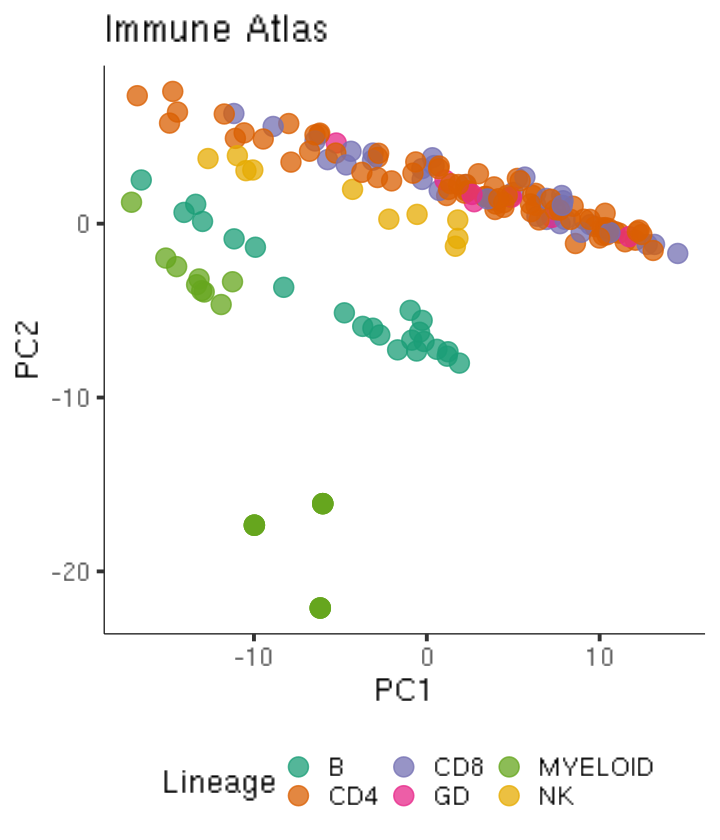

In [20]:
options(repr.plot.width=6, repr.plot.height=7)

merge(pca.x, atac.meta, by="Group.ID") %>%
    dplyr::filter(PC1 < 25, PC2 < 25) %>%
    as.data.frame() %>%
    ggplot() +
    geom_point(aes(x=PC1, y=PC2, color=Lineage), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    labs(color="Lineage") +
    ggtitle("Immune Atlas") +
    ggplot_theme

# ggsave("03_Functional_Interpretation/results/immune_normalized_peak_count_pca.svg", width=6, height=7)

In [21]:
set.seed(89734987)
tsne.res <- Rtsne(as.matrix(shape.features), num_threads=15, perplexity=10, check_duplicates=F)

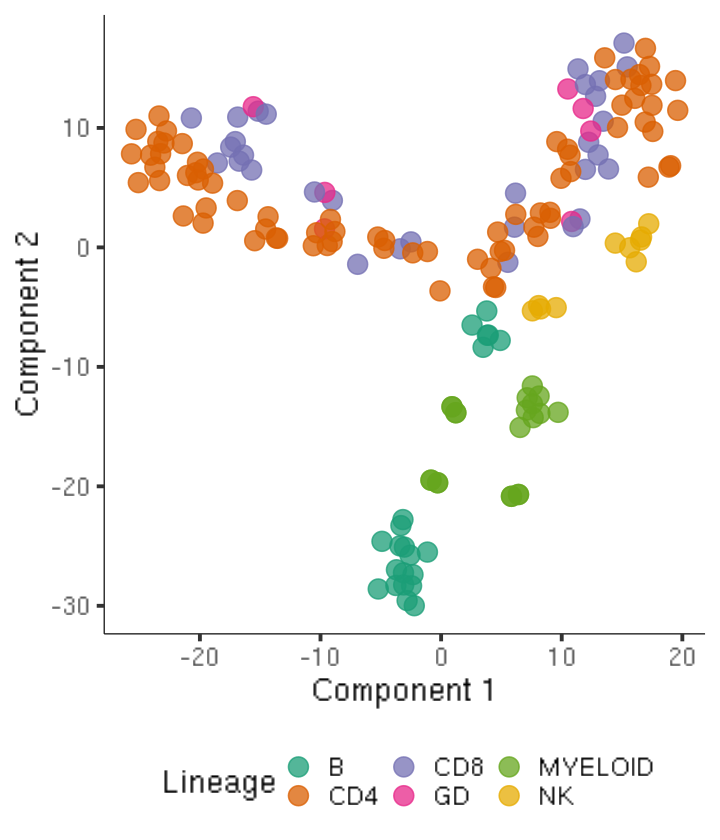

In [22]:
options(repr.plot.width=6, repr.plot.height=7)

tsne.res$Y %>%
    as.data.frame() %>%
    dplyr::select(Comp1=1, Comp2=2) %>%
    dplyr::mutate(Sample=data.mtx$Group.ID) %>%
    merge(., atac.meta, by.x="Sample", by.y="Group.ID") %>%
    ggplot() +
    geom_point(aes(x=Comp1, y=Comp2, color=Lineage), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    xlab("Component 1") + ylab("Component 2") +
    ggplot_theme

# ggsave("03_Functional_Interpretation/results/immune_normalized_peak_count_tsne.svg", width=6, height=7)

## Linear Model

In [23]:
design <- model.matrix( ~ 0 + group + donor + tss.score)

In [24]:
fit <- lmFit(t(shape.features), design)

Create contrasts to compare stimulated cell types against control cell types.

In [25]:
group.contrasts <- matrix(0, nrow=ncol(design), ncol=length(cell.types))
rownames(group.contrasts) <- colnames(design)
colnames(group.contrasts) <- cell.types

In [26]:
for (cell.type in cell.types) {
    
    group.contrasts[paste0("group", cell.type, ".Control"), cell.type] = -1
    group.contrasts[paste0("group", cell.type, ".Stimulated"), cell.type] = 1
}

Run a simple linear model across all the peaks.

In [27]:
ds.peaks <- rbindlist(lapply(1:ncol(group.contrasts), function(i) {
    de.res = eBayes(contrasts.fit(fit, group.contrasts[,i]))
    de.res.table = topTable(de.res, sort.by="p", n=Inf)
    
    contrast.cell.type = colnames(group.contrasts)[i]

    de.res.table %>%
        dplyr::mutate(Cell.Type=contrast.cell.type) %>%
        dplyr::mutate(Peak.ID=rownames(.)) %>%
        dplyr::mutate(Peak.Chr=sapply(strsplit(Peak.ID, ":"), function(x) { x[1] })) %>%
        dplyr::mutate(Peak.Coords=sapply(strsplit(Peak.ID, ":"), function(x) { x[2] })) %>%
        dplyr::mutate(Peak.Start=as.numeric(sapply(strsplit(Peak.Coords, "-"), function(x) { x[1] }))) %>%
        dplyr::mutate(Peak.End=as.numeric(sapply(strsplit(Peak.Coords, "-"), function(x) { x[2] }))) %>%
        dplyr::select(Cell.Type, Peak.ID, Peak.Chr, Peak.Start, Peak.End, logFC, AveExpr, t, P.Value, adj.P.Val, B)
}))

In [28]:
ds.peak.set <- ds.peaks %>%
    dplyr::filter(adj.P.Val < 0.01)

In [29]:
length(unique(ds.peak.set$Peak.ID))

[1] 16178

In [30]:
table(ds.peak.set$Cell.Type)


                  Bulk_B                 CD8pos_T  Central_memory_CD8pos_T 
                    1023                     1998                     3422 
       Effector_CD4pos_T Effector_memory_CD8pos_T      Follicular_T_Helper 
                    5249                     1853                     7300 
           Gamma_delta_T                Mature_NK                    Mem_B 
                     911                       73                      779 
            Memory_Teffs             Memory_Tregs                Monocytes 
                    6005                     2517                      108 
                 Naive_B              Naive_CD8_T              Naive_Teffs 
                    1040                     1748                     7257 
             Naive_Tregs             Regulatory_T           Th1_precursors 
                     250                     3234                     6037 
         Th17_precursors           Th2_precursors 
                    4311            

In [31]:
head(ds.peak.set)

Cell.Type,Peak.ID,Peak.Chr,Peak.Start,Peak.End,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Monocytes,8:26382095-26384716,8,26382095,26384716,-0.2114626,-0.001963265,-8.465994,7.007800e-14,4.969091e-09,19.972236
Monocytes,12:57279816-57281063,12,57279816,57281063,0.1908669,0.006329622,7.768891,2.878854e-12,1.020669e-07,16.664753
Monocytes,12:39990020-39991169,12,39990020,39991169,-0.2329860,0.001711051,-6.476917,2.107963e-09,4.518278e-05,10.768454
Monocytes,X:40579957-40582072,X,40579957,40582072,-0.1726631,-0.000925039,-6.438248,2.548811e-09,4.518278e-05,10.598439
Monocytes,2:189142991-189143762,2,189142991,189143762,-0.2271639,0.002667955,-6.286680,5.338837e-09,7.571325e-05,9.936468
Monocytes,3:189323909-189325647,3,189323909,189325647,-0.1232124,0.002313624,-6.102094,1.299207e-08,1.408768e-04,9.140248


In [32]:
write.csv(ds.peak.set, "/nfs/users/nfs_n/nm18/gains_team282/epigenetics/regulation/immune/ds_peaks.csv", quote=F, row.names=F)

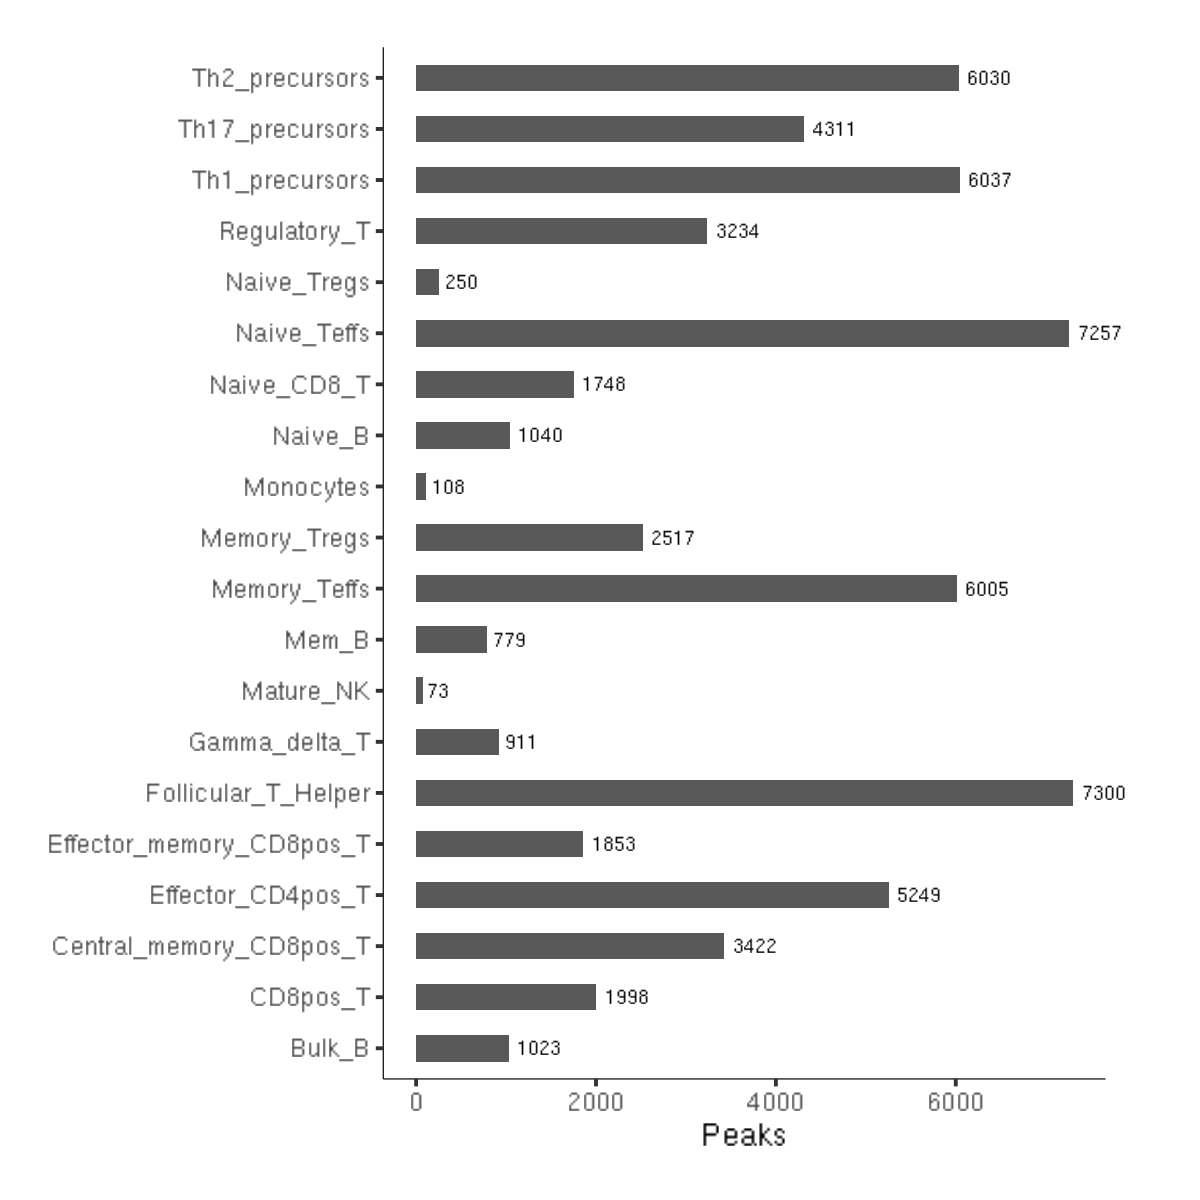

In [33]:
options(repr.plot.width=10, repr.plot.height=10)

ds.peak.set %>%
    dplyr::group_by(Cell.Type) %>%
    dplyr::summarize(Peaks=n(), .groups="drop") %>%
    ggplot() +
    geom_bar(aes(x=Cell.Type, y=Peaks), stat="identity", width=0.5) +
    geom_text(aes(x=Cell.Type, y=Peaks, label=Peaks), hjust=-0.2, vjust=0.5) +
    scale_fill_brewer(palette="Pastel1") +
    coord_flip(clip="off") +
    ggplot_theme +
    theme(axis.title.y.left=element_blank(), plot.margin=margin(1, 2, 1, 1, "cm"))

ggsave("03_Functional_Interpretation/results/immune_ds_peak_counts.svg", width=10, height=10)

In [34]:
da.peak.set <- read.csv("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/immune/da_peak_set.csv", row.names=1)

In [35]:
head(da.peak.set)

,Contrast,Cell.Type,Peak.ID,Peak.Chr,Peak.Start,Peak.End,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,10:7192161-7194489,10,7192161,7194489,2.743348,4.088902,8.988912,1.086518e-15,2.836496e-10,25.12618
2,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,2:196100794-196102222,2,196100794,196102222,2.907630,2.901611,8.792701,3.435012e-15,4.483773e-10,23.94365
3,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,7:139915940-139917596,7,139915940,139917596,2.731087,4.517130,8.646139,8.076779e-15,5.409885e-10,23.18395
4,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,10:90977075-90978744,10,90977075,90978744,3.475055,1.411035,8.641681,8.289011e-15,5.409885e-10,22.53906
5,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,13:50244341-50245970,13,50244341,50245970,4.221790,3.673378,8.455191,2.444102e-14,1.161934e-09,21.82311
6,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,16:57376818-57378224,16,57376818,57378224,2.987056,2.379907,8.439857,2.670469e-14,1.161934e-09,21.80542


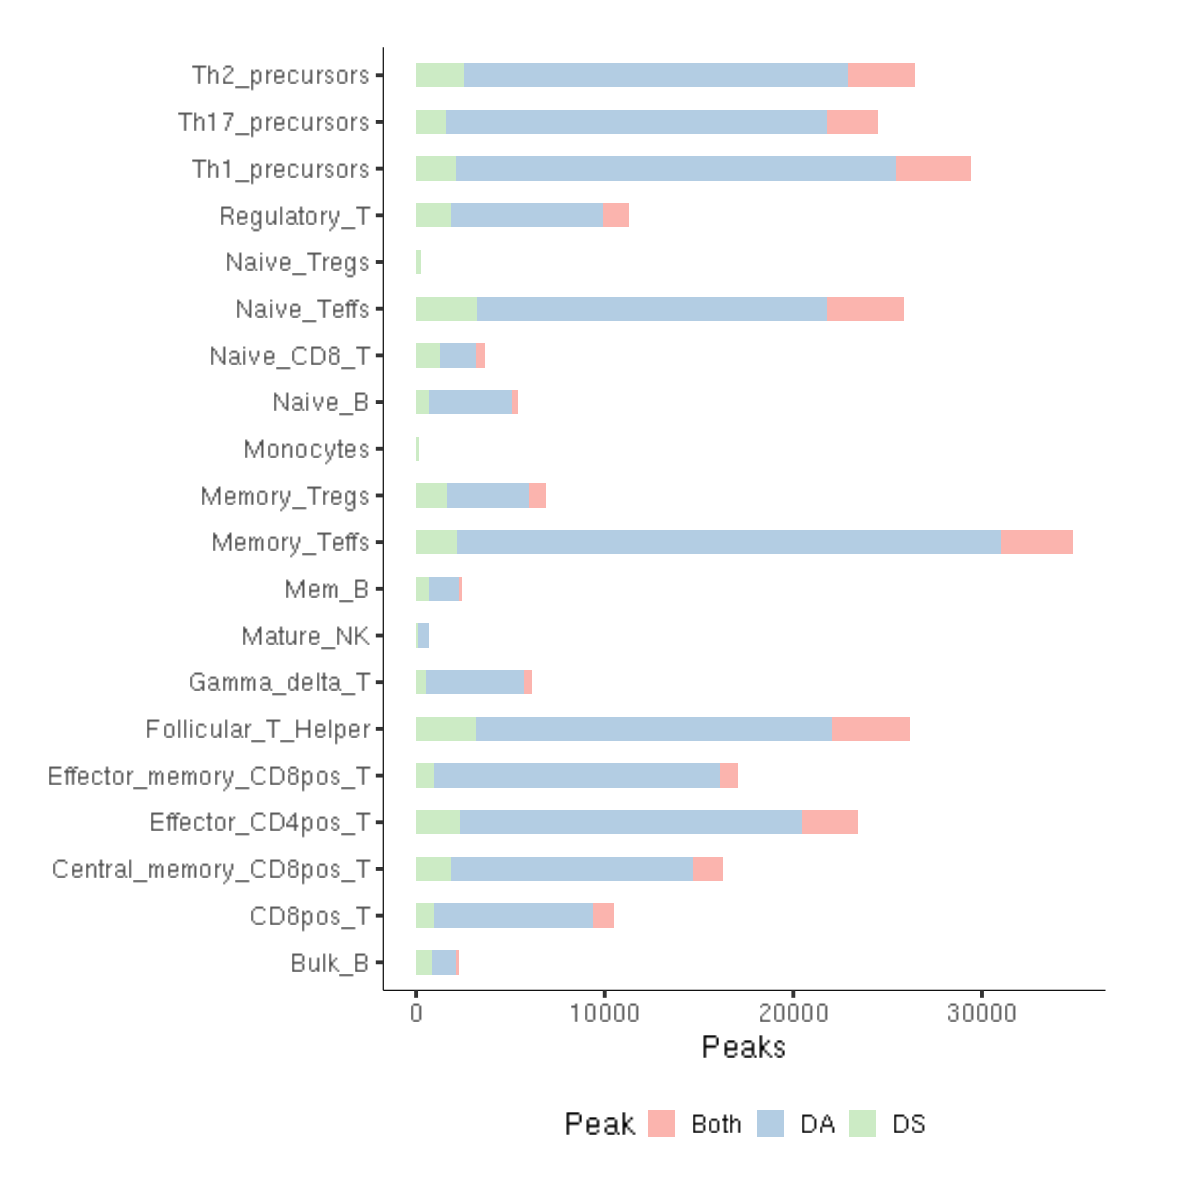

In [36]:
merge(ds.peak.set, da.peak.set, by=c("Peak.ID", "Cell.Type"), all=TRUE) %>%
    dplyr::mutate(DS=!is.na(logFC.x), DA=!is.na(logFC.y)) %>%
    dplyr::select(Peak.ID, Cell.Type, DS, DA) %>%
    dplyr::mutate(Peak=ifelse(DS & DA, "Both", ifelse(DS, "DS", "DA"))) %>%
    dplyr::group_by(Cell.Type, Peak) %>%
    dplyr::summarize(Peaks=n(), .groups="drop") %>%
    ggplot() +
    geom_bar(aes(x=Cell.Type, y=Peaks, fill=Peak), stat="identity", width=0.5) +
    scale_fill_brewer(palette="Pastel1") +
    coord_flip(clip="off") +
    ggplot_theme +
    theme(axis.title.y.left=element_blank(), plot.margin=margin(1, 2, 1, 1, "cm"))